In [207]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [208]:
path='C:\\Kaggle\\Restaurants\\data\\'

In [209]:
test_dates = pd.DataFrame(pd.date_range('2017-04-23','2017-05-31', freq='D'))

In [210]:
sample_submission=pd.read_csv(path+'sample_submission.csv')
lst_stores=list(sample_submission['id'].apply(lambda x:x[:-11]).unique())

In [211]:
air_visit_data=pd.read_csv(path+'air_visit_data.csv')
air_visit_data['visit']=pd.to_datetime(air_visit_data['visit_date'])
air_visit_data=air_visit_data[air_visit_data.air_store_id.isin(lst_stores)]
date_info=pd.read_csv(path+'date_info.csv')
date_info['visit']=pd.to_datetime(date_info['calendar_date'])
date_info['day']=date_info.index+1
date_info['week_day']=date_info['visit'].dt.dayofweek 
date_info['weekend']=date_info.apply(lambda x:1 if x['visit'].dayofweek in [5,6] else 0,axis=1)
golden_week=list(pd.date_range('2016-04-29','2016-05-07', freq='D').union(pd.date_range('2017-04-28','2017-05-06', freq='D')))
date_info['fl_gw']=0
date_info.loc[date_info.visit.isin(golden_week),'fl_gw']=1
date_info['fl_holiday1']=date_info.apply(lambda x: 1 if x['holiday_flg']==1|x['weekend']==1 else 0,axis=1)
date_info['fl_holiday2']=date_info.apply(lambda x: 1 if x['holiday_flg']==1|x['weekend']==1|x['fl_gw']==1 else 0,axis=1)

In [212]:
air_visit_data=air_visit_data.merge(date_info,on='visit')
air_visit_data=air_visit_data.drop(['visit_date','calendar_date','day_of_week','holiday_flg','fl_gw'],axis=1)
air_visit_data['shift_day']=air_visit_data.sort_values('day').groupby(['air_store_id'])['day'].shift(1).fillna(air_visit_data.day)
air_visit_data['diff']=air_visit_data['day']-air_visit_data['shift_day']
air_visit_data['visitors']=np.log1p(air_visit_data['visitors'])
filt=air_visit_data.loc[(air_visit_data['diff']>30),['air_store_id','visit']]
filt.columns=['air_store_id','start_date']
filt=filt.groupby('air_store_id')['start_date'].max().reset_index()
air_visit_data=air_visit_data.merge(filt, on='air_store_id',how='left').fillna(pd.to_datetime('1900-01-01'))
air_visit_data=air_visit_data[air_visit_data['visit']>=air_visit_data['start_date']]
air_visit_data=air_visit_data.drop(['shift_day','diff','start_date'],axis=1)

In [213]:
air_store_info=pd.read_csv(path+'air_store_info.csv')
air_store_info['air_area']=air_store_info['air_area_name'].apply(lambda x: x.split()[0])
air_store_info.head()
df=pd.merge(air_visit_data, air_store_info, on='air_store_id')
tmp=df.groupby(['air_area'])['visitors'].mean().reset_index()
tmp.columns=list(tmp.columns[:-1])+['area']
air_store_info=air_store_info.merge(tmp, on='air_area')
tmp=df.groupby(['air_genre_name'])['visitors'].mean().reset_index()
tmp.columns=list(tmp.columns[:-1])+['genre']
air_store_info=air_store_info.merge(tmp, on='air_genre_name')
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,air_area,area,genre
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,2.957459,2.892934
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,2.957459,2.892934
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,2.957459,2.892934
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,2.957459,2.892934
4,air_42c9aa6d617c5057,Italian/French,Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,34.756950,134.841177,Hyōgo-ken,2.957459,2.892934


In [248]:
lst_short_stores=['air_b259b4e4a51a690d','air_7bc6ca04d7b0f3b8','air_fb44f566d4f64a4e','air_900d755ebd2f7bbd', 
                  'air_25c583983246b7b0','air_e42bdc3377d1eee7','air_5e939e005bd34633','air_51281cd059d7b89b', 
                  'air_a9a380530c1e121f','air_789103bf53b8096b','air_1509881b22965b34','air_a17f0778617c76e2',
                  'air_1c0b150f9e696a5f','air_cf5ab75a0afb8af9','air_8e492076a1179383','air_8e8f42f047537154',
                  'air_bb4ff06cd661ee9b','air_8110d68cc869b85e','air_9c6787aa03a45586']

In [215]:
class LinearReg():
    def fit(self, X):
        codes = X.air_store_id.unique()
        days = np.arange(7)
        self.d = {}
        index2 = [X.week_day == i for i in range(7)]
        for code in codes:
            self.d[code] = {}
            index1 = X.air_store_id == code
            for day in days:
                index = index1 & index2[day]
                self.d[code][day] = LinearRegression()
                x = X[index]
                try:
                    self.d[code][day].fit(x.day.values.reshape(len(x), 1), x.visitors)
                except:
                    pass
    def predict(self, X):
        prediction = []
        for day, code, weekday in X[['day', 'air_store_id', 'week_day']].values:
            try:
                prediction.append(self.d[code][weekday].predict(day)[0])
            except:
                prediction.append(-999)
        return prediction
    
class LinearReg2():
    def fit(self, X):
        codes = X.air_store_id.unique()
        days = [True, False]
        self.d = {}
        index2 = [X.weekend == i for i in days]
        for code in codes:
            self.d[code] = {}
            index1 = X.air_store_id == code
            for day in days:
                index = index1 & index2[day]
                self.d[code][day] = LinearRegression()
                x = X[index]
                self.d[code][day].fit(x.day.values.reshape(len(x), 1), x.visitors)
    def predict(self, X):
        prediction = []
        for day, code, weekday in X[['day', 'air_store_id', 'weekend']].values:
            prediction.append(self.d[code][weekday].predict(day)[0])
        return prediction
    
a = [0.93]**np.arange(50, 0, -1)
a = a / a.sum()

a2 = [0.7]**np.arange(15, 0, -1)
a2 = a2 / a2.sum()

def create_weighted_mean(series):
    l=len(series)
    return a[:l].dot(series[-np.minimum(50,l):])
def create_weighted_mean2(series):
    l=len(series)
    return a2[:l].dot(series[-np.minimum(15,l):])

In [216]:
def mean_error(s):
    e = [[] for i in range(40)]
    n = len(s)
    for i in range(1, 81):
        m = np.mean(s[:n - i])
        left = np.maximum(1, i - 39)
        right = np.minimum(i, 40)
        for j in range(left, right + 1):
            e[j - 1].append((m - s[n - i + j - 1])**2)
    for i in range(40):
        e[i] = np.mean(e[i])
    return e 
def weighted_mean_error(s):
    e = [[] for i in range(40)]
    n = len(s)
    for i in range(1, 81):
        m = create_weighted_mean(s[:n - i])
        left = np.maximum(1, i - 39)
        right = np.minimum(i, 40)
        for j in range(left, right + 1):
            e[j - 1].append((m - s[n - i + j - 1])**2)
    for i in range(40):
        e[i] = np.mean(e[i])
    return e 
def mean_last_year_error(s):
    e = [[] for i in range(40)]
    s = s[-182-60:]
    n = len(s)
    for i in range(1, 81):
        m = np.mean(s[:n - i])
        left = np.maximum(1, i - 39)
        right = np.minimum(i, 40)
        for j in range(left, right + 1):
            e[j - 1].append((m - s[n - i + j - 1])**2)
    for i in range(40):
        e[i] = np.mean(e[i])
    return e 
def mean_last_month_error(s):
    e = [[] for i in range(40)]
    n = len(s)
    for i in range(1, 81):
        m = np.mean(s[n - i - 40:n - i])
        left = np.maximum(1, i - 39)
        right = np.minimum(i, 40)
        for j in range(left, right + 1):
            e[j - 1].append((m - s[n - i + j - 1])**2)
    for i in range(40):
        e[i] = np.mean(e[i])
    return e 
def mean_last_week_error(s):
    e = [[] for i in range(40)]
    n = len(s)
    for i in range(1, 81):
        m = np.mean(s[n - i - 7:n - i])
        left = np.maximum(1, i - 39)
        right = np.minimum(i, 40)
        for j in range(left, right + 1):
            e[j - 1].append((m - s[n - i + j - 1])**2)
    for i in range(40):
        e[i] = np.mean(e[i])
    return e 
def regression_error(s):
    e = [[] for i in range(40)]
    n = len(s)
    model = LinearRegression()
    for i in range(1, 81):
        l = len(s[:n - i])
        model.fit(np.arange(0, l).reshape(l, 1), s[:n - i])
        m = model.predict(np.arange(l, l + 40).reshape(40, 1))
        left = np.maximum(1, i - 39)
        right = np.minimum(i, 40)
        for j in range(left, right + 1):
            e[j - 1].append((m[j - 1] - s[n - i + j - 1])**2)
    for i in range(40):
        e[i] = np.mean(e[i])
    return e 
def regression_year_error(s):
    e = [[] for i in range(40)]
    n = len(s)
    model = LinearRegression()
    for i in range(1, 81):
        l = len(s[max(0, n - i - 182):n - i])
        model.fit(np.arange(0, l).reshape(l, 1), s[max(0, n - i - 182):n - i])
        m = model.predict(np.arange(l, l + 40).reshape(40, 1))
        left = np.maximum(1, i - 39)
        right = np.minimum(i, 40)
        for j in range(left, right + 1):
            e[j - 1].append((m[j - 1] - s[n - i + j - 1])**2)
    for i in range(40):
        e[i] = np.mean(e[i])
    return e 
def regression_month_error(s):
    e = [[] for i in range(40)]
    n = len(s)
    model = LinearRegression()
    for i in range(1, 81):
        l = len(s[n - i - 40:n - i])
        model.fit(np.arange(0, l).reshape(l, 1), s[n - i - 40:n - i])
        m = model.predict(np.arange(l, l + 40).reshape(40, 1))
        left = np.maximum(1, i - 39)
        right = np.minimum(i, 40)
        for j in range(left, right + 1):
            e[j - 1].append((m[j - 1] - s[n - i + j - 1])**2)
    for i in range(40):
        e[i] = np.mean(e[i])
    return e 
def regression_very_good_error(s):
    try:
        e = [[] for i in range(40)]
        n = len(s)
        models = [LinearRegression() for i in range(7)]
        for i in range(1, 81):
            l = len(s[:n - i])
            for k in range(7):
                y = s[:n - i][k::7]
                X = np.arange(0, l)[k::7]
                X = X.reshape(len(X), 1)
                models[k].fit(X, y)
            left = np.maximum(1, i - 39)
            right = np.minimum(i, 40)
            for j in range(left, right + 1):
                time = n - i + j - 1
                e[j - 1].append((models[time % 7].predict(time)[0] - s[time])**2)
        for i in range(40):
            e[i] = np.mean(e[i])
    except:
        for i in range(40):
            e[i] = 0
    return e 
def week_visitors_mean_error(s):
    e = [[] for i in range(40)]
    n = len(s)
    for i in range(1, 81):
        l = len(s[:n - i])
        m = [np.mean(s[:n - i][k::7]) for k in range(7)]
        left = np.maximum(1, i - 39)
        right = np.minimum(i, 40)
        for j in range(left, right + 1):
            time = n - i + j - 1
            e[j - 1].append((m[time % 7] - s[time])**2)
    for i in range(40):
        e[i] = np.mean(e[i])
    return e 
def week_visitors_mean_year_error(s):
    e = [[] for i in range(40)]
    s = s[-182-60:]
    n = len(s)
    for i in range(1, 81):
        l = len(s[:n - i])
        m = [np.mean(s[:n - i][k::7]) for k in range(7)]
        left = np.maximum(1, i - 39)
        right = np.minimum(i, 40)
        for j in range(left, right + 1):
            time = n - i + j - 1
            e[j - 1].append((m[time % 7] - s[time])**2)
    for i in range(40):
        e[i] = np.mean(e[i])
    return e

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001D16DBC51D0>>
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\xgboost\core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


In [217]:
def regression(x):
    clf = LinearRegression()
    clf.fit(x.day.values.reshape(len(x), 1), x.visitors)
    return clf.predict((np.arange(1, 41) + x.day.max()).reshape(40, 1))

In [218]:
def create_month_data(max_day, data, mode):
    index = (date_info.day > max_day) & (date_info.day <= max_day+40)
    X=pd.DataFrame.from_records(itertools.product(list(data.air_store_id.unique()),
                                                  list(date_info.loc[index,'visit'].values)))
    X.columns=['air_store_id','visit']
    if mode=='test':
        X=X.merge(date_info[['visit','day','week_day','weekend','fl_holiday1',
                            'fl_holiday2']], on=['visit'])
        X.visitors = np.nan
    else:
        X=X.merge(air_visit_data, on=['air_store_id','visit'],how='left')
    data = data[data.day <= max_day]
    story = data
    tmp = story.groupby(['air_store_id', 'week_day']).visitors.mean().reset_index()
    tmp.columns = list(tmp.columns[:-1]) + ['week_visitors_mean']
    X = pd.merge(X, tmp, how='left')

    
    story = data[data.day > max_day - 182]
    tmp = story.groupby(['air_store_id', 'week_day']).visitors.mean().reset_index()
    tmp.columns = list(tmp.columns[:-1]) + ['week_visitors_mean_year']
    X = pd.merge(X, tmp, how='left')
    
    std = data.groupby(['air_store_id', 'week_day'])['visitors'].mean().reset_index().groupby(['air_store_id'])['visitors'].std()
    X['t'] = X.day - max_day
    
    X = X.sort_values(['air_store_id', 'day']).set_index('air_store_id')

    story = data
    X['mean_all'] = story.visitors.groupby(by=story.air_store_id).mean()
    X['weighted_mean'] = story.visitors.groupby(by=story.air_store_id).apply(create_weighted_mean)
    
    story = data[data.day > max_day - 182]
    X['mean_last_year'] = story.visitors.groupby(by=story.air_store_id).mean()
    story = data[data.day > max_day - 30]
    X['mean_last_month'] = story.visitors.groupby(by=story.air_store_id).mean()
    story = data[data.day > max_day - 7]
    X['mean_last_week'] = story.visitors.groupby(by=story.air_store_id).mean()
    X['last_day'] = data[data.day == max_day].set_index('air_store_id').visitors
    story = data
    X['regression'] = np.concatenate(story.groupby(story.air_store_id).apply(regression).values)
    story = data[data.day > max_day - 182]
    X['regression_year'] = np.concatenate(story.groupby(story.air_store_id).apply(regression).values)
    story = data[data.day > max_day - 30]
    X['regression_month'] = np.concatenate(story.groupby(story.air_store_id).apply(regression).values)
    X['diff_mean_yaer_mean_weekday_year']  = X['mean_all'] - X['week_visitors_mean']
    good_regress= LinearReg()
    good_regress.fit(data)
    X['regression_very_good'] = good_regress.predict(X.reset_index())
    X['good'] = 0.3 * X.week_visitors_mean_year + 0.45 * X.mean_last_month + 0.25 * X.regression_very_good
    M = np.array(list(data.groupby('air_store_id').visitors.apply(list).values))
    
    w1 = np.hstack([week_visitors_mean_error(M[i]) for i in range(len(M))])
    w2 = np.hstack([regression_very_good_error(M[i]) for i in range(len(M))])
    w3 = np.hstack([weighted_mean_error(M[i]) for i in range(len(M))])
    w4 = np.hstack([mean_last_year_error(M[i]) for i in range(len(M))])
    w1 = (1 / w1)**4
    w2 = (1 / w2)**4
    w3 = (1 / w3)**4
    w4 = (1 / w4)**4
    tmp = w1 * X.week_visitors_mean +  w2 * X.regression_very_good + w3 * X.weighted_mean + w4 * X.mean_last_year
    X['very_very_good'] = tmp / (w1 + w2 + w3 + w4)
    
    X['diff_mean_all_mean_last_year'] = X['mean_all'] - X['mean_last_year']
    X['diff_last_day_regression_very_good'] = X['last_day'] - X['regression_very_good']
    
    return X

In [275]:
i=0
Xtest=pd.DataFrame()
for item in lst_stores:
    try:
        _df=air_visit_data.loc[air_visit_data['air_store_id']==item].copy()
        Xtest=Xtest.append(create_month_data(478,_df,'test'))
        if i%100==0:
            print(i)
        i=i+1
    except:
        print(item)
Xtest=Xtest[Xtest['day']<518]
Xtest.to_csv(path+'Xtest.csv')

0
100
200
300
air_7bc6ca04d7b0f3b8
400
500
air_b259b4e4a51a690d
600
700
800
air_fb44f566d4f64a4e


In [276]:
max_data=478
i=0
lst_days=np.array(range(max_data, 1, -40))
Xtrain=pd.DataFrame()
for item in lst_stores:
    try:
        _df=air_visit_data.loc[air_visit_data['air_store_id']==item].sort_values('day').copy()
        start_day=_df.iloc[40]['day']
        start_day=min(lst_days[lst_days>start_day])
        Xtrain=Xtrain.append(pd.concat([create_month_data(i, _df,'train') for i in range(start_day, 478 - 39, 40)]))
        if i%100==0:
            print(i)
        i=i+1
    except:
        print(item)
#for item in ['air_52a08ef3efdb4bb0']:
#        _df=air_visit_data.loc[air_visit_data['air_store_id']==item].sort_values('day').copy()
#        start_day=_df.iloc[30]['day']
#        start_day=min(lst_days[lst_days>start_day])
#        Xtrain=Xtrain.append(pd.concat([create_month_data(i, _df,'train') for i in range(start_day, 478 - 39, 40)]))
Xtrain = Xtrain[pd.notnull(Xtrain['visitors'])]
Xtrain.to_csv(path+'Xtrain.csv')

0
air_1509881b22965b34
air_1c0b150f9e696a5f
air_25c583983246b7b0
100
200
air_51281cd059d7b89b
air_5e939e005bd34633
300
air_6b65745d432fd77f
air_789103bf53b8096b
air_7bc6ca04d7b0f3b8
air_8110d68cc869b85e
400
air_8e8f42f047537154
air_900d755ebd2f7bbd
air_9c6787aa03a45586
500
air_a17f0778617c76e2
air_a9a380530c1e121f
air_b259b4e4a51a690d
air_bb4ff06cd661ee9b
600
air_cf5ab75a0afb8af9
700
air_e42bdc3377d1eee7
air_fb44f566d4f64a4e
800


In [279]:
short_list=['air_1509881b22965b34','air_1c0b150f9e696a5f','air_25c583983246b7b0','air_51281cd059d7b89b',
            'air_5e939e005bd34633','air_6b65745d432fd77f','air_789103bf53b8096b','air_7bc6ca04d7b0f3b8',
            'air_8110d68cc869b85e','air_8e8f42f047537154','air_900d755ebd2f7bbd','air_9c6787aa03a45586',
            'air_a17f0778617c76e2','air_a9a380530c1e121f','air_b259b4e4a51a690d','air_bb4ff06cd661ee9b',
            'air_cf5ab75a0afb8af9','air_e42bdc3377d1eee7','air_fb44f566d4f64a4e']

In [285]:
Xtrain=pd.read_csv(path+'Xtrain.csv')
Xtest=pd.read_csv(path+'Xtest.csv')
shortXtrain=pd.read_csv(path+'short_Xtrain.csv')
Xtrain=Xtrain[~(Xtrain.air_store_id.isin(short_list))]
Xtest=Xtest[~(Xtest.air_store_id.isin(short_list))]

In [286]:
Xtrain=Xtrain.merge(air_store_info, on='air_store_id')
Xtest=Xtest.merge(air_store_info, on='air_store_id')
ytrain=Xtrain['visitors']

In [289]:
cols=['week_visitors_mean',
 'week_visitors_mean_year',
 't',
 'weighted_mean',
 'mean_last_year',
 'mean_last_month',
 'mean_last_week',
 'last_day',
 'regression',
 'regression_year',
 'regression_month',
 'diff_mean_yaer_mean_weekday_year',
 'regression_very_good',
 'good',
 'very_very_good',
 'diff_mean_all_mean_last_year',
 'diff_last_day_regression_very_good',
 'latitude',
 'longitude',
 'area',
 'genre'
     ]

In [290]:
model = xgb.XGBRegressor(max_depth=7, n_estimators=150, seed=0, nthread=8, learning_rate=0.1)
model.fit(Xtrain[cols], ytrain)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=8, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [256]:
pred = model.predict(Xtest[cols])

In [257]:
def prepare_submission(Xtest, pred, shortX):
    sub=Xtest[['air_store_id','visit']].reset_index().copy()
    sub['id']=Xtest.apply(lambda x: x['air_store_id']+'_'+x['visit'],axis=1)
    sub['visitors']=np.expm1(pred)
    sub=pd.concat([sub[['id','visitors']],shortX[['id','visitors']]],axis=0)
    sub.loc[(sub['visitors']<0),'visitors']=1
    return sub    

In [258]:
submission=prepare_submission(Xtest,pred,shortXtrain)

In [259]:
submission.to_csv(path+'submission.csv',index=False)

In [273]:
submission.isnull().sum()

id          0
visitors    0
dtype: int64

In [264]:
t=submission.groupby('id')['visitors'].count().reset_index()

In [272]:
t.shape

(32019, 2)

In [294]:
max_date=478
max_date1=max_date-39
max_date2=max_date1-39
max_date3=max_date2-39
idx_train_1=Xtrain['day']<max_date1
idx_val_1=(Xtrain['day']>=max_date1)&(Xtrain['day']<max_date)
idx_train_2=Xtrain['day']<max_date2
idx_val_2=(Xtrain['day']>=max_date2)&(Xtrain['day']<max_date1)
idx_train_3=Xtrain['day']<max_date3
idx_val_3=(Xtrain['day']>=max_date3)&(Xtrain['day']<max_date2)
train_fold1=Xtrain[idx_train_1]
val_fold1=Xtrain[idx_val_1]
train_fold2=Xtrain[idx_train_2]
val_fold2=Xtrain[idx_val_2]
train_fold3=Xtrain[idx_train_2]
val_fold3=Xtrain[idx_val_3]

In [297]:
def my_cv(model,fold_train, fold_val):
    y_tr=fold_train['visitors']
    X_tr=fold_train[cols]
    y_val=fold_val['visitors']
    X_val=fold_val[cols]
    model.fit(X_tr, y_tr)
    y_pred=model.predict(X_val)
    return (mean_squared_error(y_pred, y_val))

In [298]:
my_cv(model, train_fold1, val_fold1)

0.27362820691759476

In [321]:
short_stores=air_visit_data.loc[air_visit_data.air_store_id.isin(short_list)]
short_stores=short_stores.sort_values('day').set_index('day')

In [322]:
short_stores.head()

,air_store_id,visitors,visit,week_day,weekend,fl_holiday1,fl_holiday2
day,,,,,,,
247,air_a9a380530c1e121f,3.784190,2016-09-03,5,1,0,0
254,air_a9a380530c1e121f,3.871201,2016-09-10,5,1,0,0
275,air_a9a380530c1e121f,4.025352,2016-10-01,5,1,0,0
276,air_a9a380530c1e121f,3.784190,2016-10-02,6,1,0,0
282,air_a9a380530c1e121f,4.143135,2016-10-08,5,1,0,0


In [323]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [399]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.40):
    
    data = pd.DataFrame(data.copy())
    print(data.shape)
    
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    tmp1=data[:test_index].groupby('week_day')['visitors'].mean().reset_index()
    tmp1.columns=list(tmp1.columns[:-1])+['mean_week_day']
    tmp2=data[:test_index].groupby('weekend')['visitors'].mean().reset_index()
    tmp2.columns=list(tmp2.columns[:-1])+['mean_weekend']
    data=data.merge(tmp2, on=['weekend']) 


    # выкидываем закодированные средними признаки 
    data.drop(["weekend", "week_day",'visit','fl_holiday1','fl_holiday2','air_store_id'], axis=1, inplace=True)

    data = data.fillna(method='bfill')
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(['visitors'], axis=1)
    y_train = data.loc[:test_index]['visitors']
    X_test = data.loc[test_index:].drop(['visitors'], axis=1)
    y_test = data.loc[test_index:]['visitors']
    
    return X_train, X_test, y_train, y_test

(35, 7)


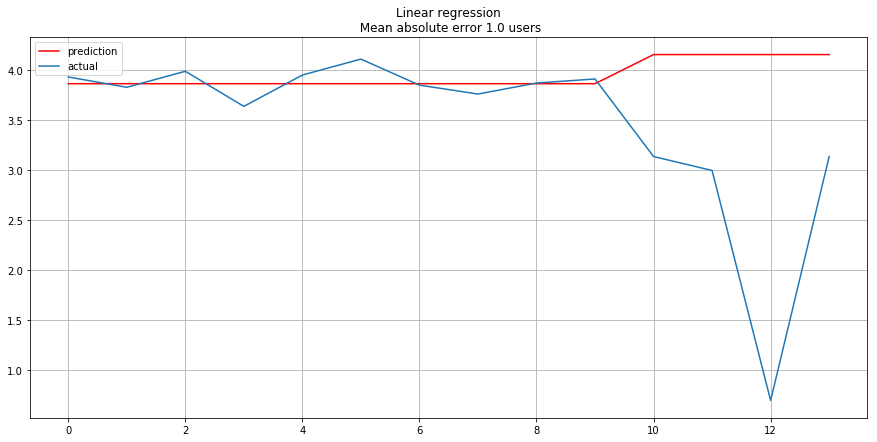

In [400]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(short_stores.loc[short_stores['air_store_id']=='air_a9a380530c1e121f'], 
                                               test_size=0.4, lag_start=1, lag_end=20)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);